# 1. Import the dependencies and pipeline modules

In [1]:
# 基础依赖
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# pipeline各模块
from data_loader import DataLoader
from data_preprocessor import DataPreprocessor
from feature_selector import FeatureSelector
from model_trainer import ModelTrainer
from pipeline_config import MODEL_CONFIG

# 2. Data loading and display

In [2]:
# ===============================================================
#          步骤 1: 原始数据加载与快速预览
# ===============================================================
from data_loader import DataLoader

loader = DataLoader()
print("🔄 正在加载原始数据...")
raw_data = loader.merge_data() 

print(f"📊 原始数据维度: {raw_data.shape}")
print("\\n📋 原始数据预览:")
display(raw_data.head())

INFO:data_loader:Merging all data tables...
INFO:data_loader:Loading diabetic data...


🔄 正在加载原始数据...


INFO:data_loader:Diabetic data loaded: (101766, 50)
INFO:data_loader:Loading ID mapping data...
INFO:data_loader:ID mapping data loaded: (67, 2)
INFO:data_loader:ID mapping data split into three tables
INFO:data_loader:Data merged successfully: (101766, 51)


📊 原始数据维度: (101766, 51)
\n📋 原始数据预览:


,encounter_id,patient_nbr,race,gender,age,weight,discharge_disposition_id,time_in_hospital,payer_code,medical_specialty,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type_desc,discharge_disposition_desc,admission_source_desc
0,2278392,8222157,Caucasian,Female,[0-10),?,25,1,?,Pediatrics-Endocrinology,...,No,No,No,No,No,No,NO,NaN,Not Mapped,Physician Referral
1,149190,55629189,Caucasian,Female,[10-20),?,1,3,?,?,...,No,No,No,No,Ch,Yes,>30,Emergency,Discharged to home,Emergency Room
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,2,?,?,...,No,No,No,No,No,Yes,NO,Emergency,Discharged to home,Emergency Room
3,500364,82442376,Caucasian,Male,[30-40),?,1,2,?,?,...,No,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,?,?,...,No,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room


## 2.1 保留首次入院记录

为了准确预测首次30天内再入院，我们只保留每个患者的第一次入院记录。这可以防止同一患者的多次再入院记录对模型产生偏见。后续的所有分析都将基于这个筛选后的数据集。

In [3]:
print(f"处理前总记录数: {len(raw_data)}")
print(f"处理前独立患者数: {raw_data['patient_nbr'].nunique()}")

# 按encounter_id排序，确保第一次入院记录在前
df_sorted = raw_data.sort_values(by='encounter_id')

# 删除重复的患者记录，只保留第一次
# 注意：我们将结果重新赋值给raw_data，以便后续单元格使用筛选后的数据
raw_data = df_sorted.drop_duplicates(subset='patient_nbr', keep='first')

print(f"\n处理后总记录数: {len(raw_data)}")
print(f"处理后独立患者数: {raw_data['patient_nbr'].nunique()}")

处理前总记录数: 101766
处理前独立患者数: 71518

处理后总记录数: 71518
处理后独立患者数: 71518


## 2.2 移除逻辑上无法再入院的患者

根据数据集的说明，部分 `discharge_disposition_id` 代表患者已经去世或被送往临终关怀机构，这些患者在生理上不可能再次入院。为了避免模型产生偏见，我们需要将这些记录移除。

In [4]:
# 定义代表去世或临终关怀的ID
hospice_or_death_ids = [11, 13, 14, 19, 20, 21]

print(f"处理前记录数: {len(raw_data)}")

# 筛选出不包含这些ID的记录
raw_data = raw_data[~raw_data['discharge_disposition_id'].isin(hospice_or_death_ids)]

print(f"移除不可能再入院的患者后，剩余记录数: {len(raw_data)}")

处理前记录数: 71518
移除不可能再入院的患者后，剩余记录数: 69973


In [5]:
import pandas as pd

# 加载数据
df = pd.read_csv('diabetic_data.csv')

# 定义判断是否为糖尿病诊断（ICD-9 250.xx）
def is_diabetes(code):
    try:
        code_str = str(code).strip()
        return code_str.startswith('250')
    except:
        return False

# 检查每条记录的三个诊断是否全是糖尿病
any_diag_diabetes = df.apply(
    lambda row: any([
        is_diabetes(row['diag_1']),
        is_diabetes(row['diag_2']),
        is_diabetes(row['diag_3'])
    ]),
    axis=1
)

# 输出统计结果
num_any_diabetes = any_diag_diabetes.sum()
total_records = len(df)
print(f"三个诊断有糖尿病的记录数: {num_any_diabetes}")
print(f"占总记录数的比例: {num_any_diabetes / total_records:.4%}")

# 展示前几条全为糖尿病的记录
display(df[any_diag_diabetes].head())

三个诊断有糖尿病的记录数: 38024
占总记录数的比例: 37.3641%


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [6]:
import pandas as pd

# 加载数据
df = pd.read_csv('diabetic_data.csv')

# 定义判断是否为糖尿病诊断（ICD-9 250.xx）
def is_diabetes(code):
    try:
        code_str = str(code).strip()
        return code_str.startswith('250')
    except:
        return False

# 检查每条记录的主诊断是是糖尿病
all_diag_diabetes = df.apply(
    lambda row: all([
        is_diabetes(row['diag_1']),
        
    ]),
    axis=1
)

# 输出统计结果
num_all_diabetes = all_diag_diabetes.sum()
total_records = len(df)
print(f"主诊断为糖尿病的记录数: {num_all_diabetes}")
print(f"占总记录数的比例: {num_all_diabetes / total_records:.4%}")

# 展示前几条全为糖尿病的记录
display(df[all_diag_diabetes].head())

主诊断为糖尿病的记录数: 8757
占总记录数的比例: 8.6050%


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
10,28236,89869032,AfricanAmerican,Female,[40-50),?,1,1,7,9,...,No,Steady,No,No,No,No,No,No,Yes,>30
52,590346,37746639,AfricanAmerican,Female,[40-50),?,1,6,7,8,...,No,Steady,No,No,No,No,No,No,Yes,>30
56,630342,93232917,AfricanAmerican,Female,[50-60),?,3,6,2,9,...,No,Steady,No,No,No,No,No,No,Yes,>30
60,676422,63754317,AfricanAmerican,Female,[70-80),?,1,1,7,4,...,No,Steady,No,No,No,No,No,No,Yes,>30


# 3. Data Preprocessing and EDA

In [7]:
preprocessor = DataPreprocessor()
df = preprocessor.apply_feature_engineering(raw_data)
df = preprocessor.prepare_target_variable(df)
print(f"特征工程后数据维度: {df.shape}")
display(df.head())

INFO:data_preprocessor:Applying feature engineering...
INFO:data_preprocessor:Original number of encounters: 69973
INFO:data_preprocessor:Encounters after keeping first admission: 69973
INFO:data_preprocessor:Removed 0 records for hospice/death dispositions.
INFO:data_preprocessor:Encounters after removing hospice/death: 69973
INFO:data_preprocessor:Handling missing values based on notebook's standard...
INFO:data_preprocessor:Replaced '?' with NaN.
INFO:data_preprocessor:🔴 Dropped columns with >50.0% missing: ['weight', 'max_glu_serum', 'A1Cresult']
INFO:data_preprocessor:🟡 Filling specified columns with 'Unknown': ['medical_specialty', 'payer_code', 'race', 'diag_1', 'diag_2', 'diag_3', 'admission_type_desc', 'discharge_disposition_desc', 'admission_source_desc']
INFO:data_preprocessor:✅ All missing values have been handled successfully.
INFO:data_preprocessor:Creating age-related features...
INFO:data_preprocessor:Creating diagnosis-related features...
INFO:data_preprocessor:Creatin

特征工程后数据维度: (69973, 56)


,encounter_id,patient_nbr,race,gender,age,discharge_disposition_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,discharge_disposition_desc,admission_source_desc,age_midpoint,age_group,diag_1_category,diag_2_category,diag_3_category,comorbidity,encounter_index,readmitted_binary
8,12522,48330783,Caucasian,Female,[80-90),1,13,Unknown,Unknown,68,...,Discharged to home,Transfer from a hospital,125,80-90,circulatory,circulatory,other,2,1,0
9,15738,63555939,Caucasian,Female,[90-100),3,12,Unknown,InternalMedicine,33,...,Discharged/transferred to SNF,Transfer from a hospital,140,90-100,circulatory,neoplasms,respiratory,2,1,0
4,16680,42519267,Caucasian,Male,[40-50),1,1,Unknown,Unknown,51,...,Discharged to home,Emergency Room,65,40-50,neoplasms,neoplasms,diabetes,2,1,0
10,28236,89869032,AfricanAmerican,Female,[40-50),1,9,Unknown,Unknown,47,...,Discharged to home,Emergency Room,65,40-50,diabetes,circulatory,injuries,2,1,0
5,35754,82637451,Caucasian,Male,[50-60),1,3,Unknown,Unknown,31,...,Discharged to home,Clinic Referral,80,50-60,circulatory,circulatory,diabetes,2,1,0


## 3.1 Missuing data handling

In [8]:
# 3.1 基础缺失值统计
print("=== 基础缺失值统计 ===")
missing_counts = raw_data.isnull().sum()
missing_percentage = (missing_counts / len(raw_data)) * 100

missing_df = pd.DataFrame({
    'Column': missing_counts.index,
    'Missing_Count': missing_counts.values,
    'Missing_Percentage': missing_percentage.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

print(f"总共有 {len(missing_df)} 个列存在缺失值")
display(missing_df)

=== 基础缺失值统计 ===
总共有 5 个列存在缺失值


,Column,Missing_Count,Missing_Percentage
20,max_glu_serum,66625,95.215297
21,A1Cresult,57128,81.642919
50,admission_source_desc,4820,6.888371
48,admission_type_desc,4516,6.453918
49,discharge_disposition_desc,2474,3.535649


In [9]:
# 3.2 检查特殊字符 '?' 表示的缺失值
print("=== 特殊字符 '?' 统计 ===")
question_mark_counts = (raw_data == '?').sum()
question_mark_percentage = (question_mark_counts / len(raw_data)) * 100

question_mark_df = pd.DataFrame({
    'Column': question_mark_counts.index,
    'Question_Mark_Count': question_mark_counts.values,
    'Question_Mark_Percentage': question_mark_percentage.values
})
question_mark_df = question_mark_df[question_mark_df['Question_Mark_Count'] > 0].sort_values('Question_Mark_Percentage', ascending=False)

print(f"总共有 {len(question_mark_df)} 个列包含 '?' 字符")
display(question_mark_df)

=== 特殊字符 '?' 统计 ===
总共有 7 个列包含 '?' 字符


,Column,Question_Mark_Count,Question_Mark_Percentage
5,weight,67185,96.015606
9,medical_specialty,33639,48.074257
8,payer_code,30415,43.466766
2,race,1918,2.741057
18,diag_3,1224,1.749246
17,diag_2,293,0.418733
16,diag_1,10,0.014291


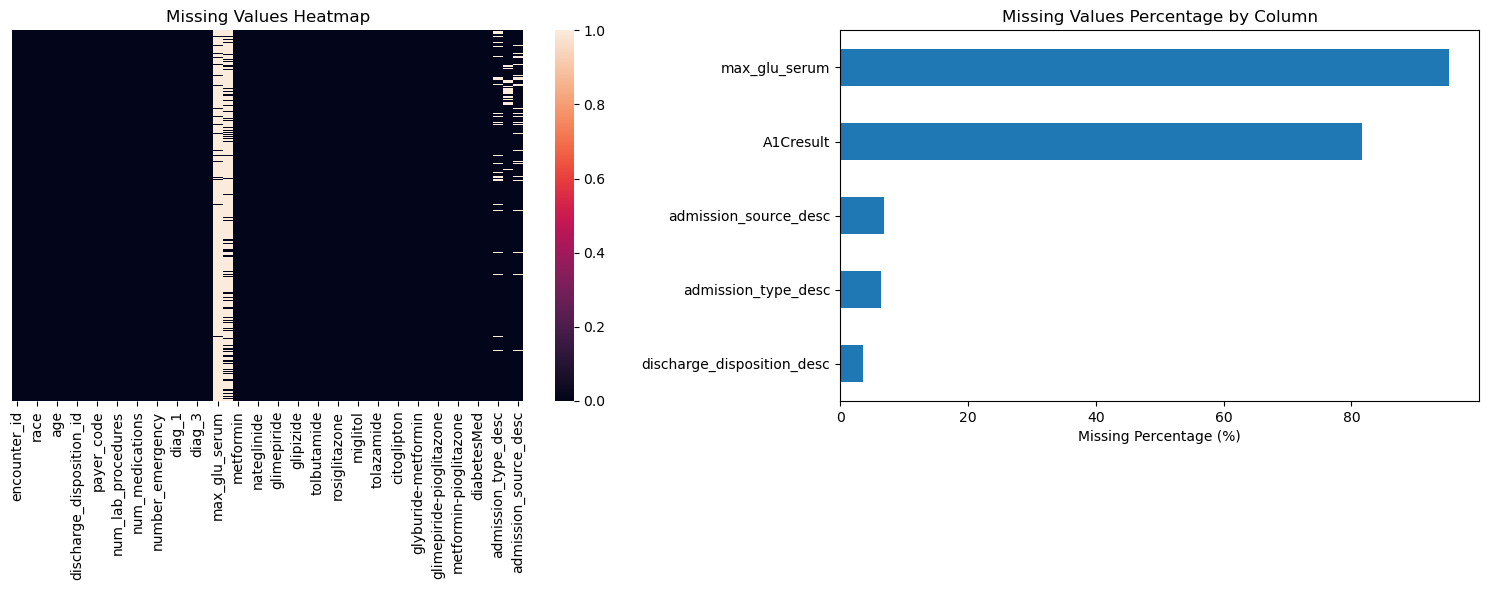

In [10]:
# 3.3 缺失值可视化
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 缺失值热力图
missing_data = raw_data.isnull()
sns.heatmap(missing_data, cbar=True, yticklabels=False, ax=axes[0])
axes[0].set_title('Missing Values Heatmap')

# 缺失值百分比条形图
missing_percentage_sorted = missing_percentage[missing_percentage > 0].sort_values(ascending=True)
missing_percentage_sorted.plot(kind='barh', ax=axes[1])
axes[1].set_title('Missing Values Percentage by Column')
axes[1].set_xlabel('Missing Percentage (%)')

plt.tight_layout()
plt.show()

In [11]:
# 3.4 缺失值处理决策（与Pipeline逻辑完全一致）
print("=== 缺失值处理决策（与Pipeline逻辑一致） ===")
print("基于data_preprocessor.py中的处理标准，我们生成以下决策表：")
print()

# --- 为了准确分析，先模拟pipeline的第一步：将'?'替换为NaN ---
analysis_df = raw_data.replace('?', np.nan)
missing_percentage = (analysis_df.isnull().sum() / len(analysis_df)) * 100

# --- 定义与pipeline完全一致的阈值和填充列 ---
drop_missing_threshold = 50.0
cols_to_fill_with_unknown = [
    'medical_specialty', 'payer_code', 'race',
    'diag_1', 'diag_2', 'diag_3',
    'admission_type_desc', 'discharge_disposition_desc', 'admission_source_desc'
]

# --- 生成与pipeline行为一致的决策表 ---
decision_data = []
all_missing_cols_df = missing_percentage[missing_percentage > 0]

for col, percentage in all_missing_cols_df.items():
    if percentage > drop_missing_threshold:
        action = "删除"
        reason = f"缺失率 ({percentage:.1f}%) > {drop_missing_threshold}%"
    elif col in cols_to_fill_with_unknown:
        action = "保留, 用'Unknown'填充"
        reason = f"预定义的填充列"
    else:
        action = "保留, 未指定处理"
        reason = "缺失率低但未在填充列表中"

    decision_data.append([col, f"{percentage:.1f}%", action, reason])

decision_df = pd.DataFrame(decision_data, columns=['列名', '缺失率', '处理方式', '原因'])
decision_df = decision_df.sort_values('缺失率', ascending=False)

print("📋 缺失值处理决策表 (与Pipeline同步):")
display(decision_df)

=== 缺失值处理决策（与Pipeline逻辑一致） ===
基于data_preprocessor.py中的处理标准，我们生成以下决策表：

📋 缺失值处理决策表 (与Pipeline同步):


,列名,缺失率,处理方式,原因
1,weight,96.0%,删除,缺失率 (96.0%) > 50.0%
7,max_glu_serum,95.2%,删除,缺失率 (95.2%) > 50.0%
8,A1Cresult,81.6%,删除,缺失率 (81.6%) > 50.0%
11,admission_source_desc,6.9%,"保留, 用'Unknown'填充",预定义的填充列
9,admission_type_desc,6.5%,"保留, 用'Unknown'填充",预定义的填充列
3,medical_specialty,48.1%,"保留, 用'Unknown'填充",预定义的填充列
2,payer_code,43.5%,"保留, 用'Unknown'填充",预定义的填充列
10,discharge_disposition_desc,3.5%,"保留, 用'Unknown'填充",预定义的填充列
0,race,2.7%,"保留, 用'Unknown'填充",预定义的填充列
6,diag_3,1.7%,"保留, 用'Unknown'填充",预定义的填充列


## 3.2 EDA

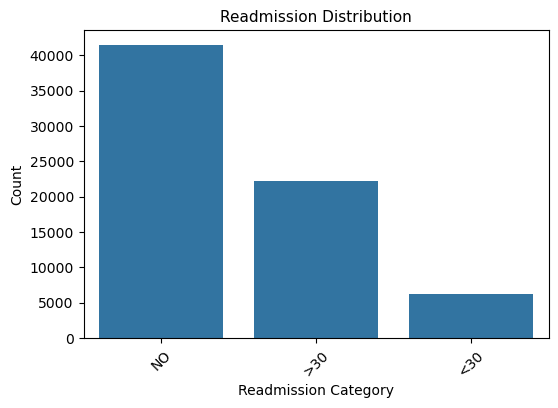

readmitted
NO     41474
>30    22222
<30     6277
Name: count, dtype: int64
No missing values found.
The average age of patients is: 95.66 years
Average stay at hospital by Age Group In Days
age_group
0-10      2.568627
10-20     2.865169
20-30     3.464764
30-40     3.634844
40-50     3.849151
50-60     3.974573
60-70     4.243943
70-80     4.505690
80-90     4.776437
90-100    4.822727
Name: time_in_hospital, dtype: float64


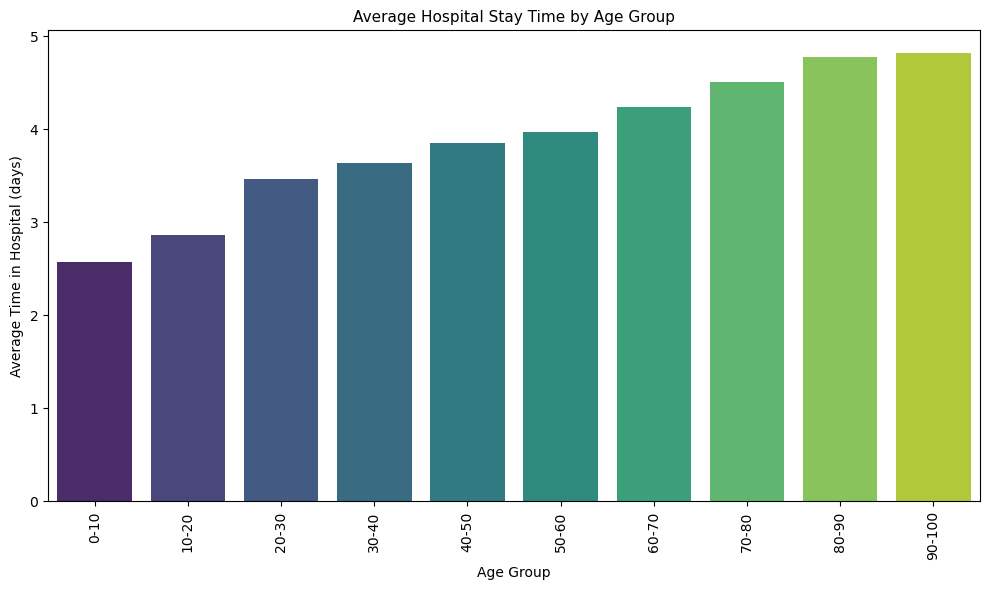

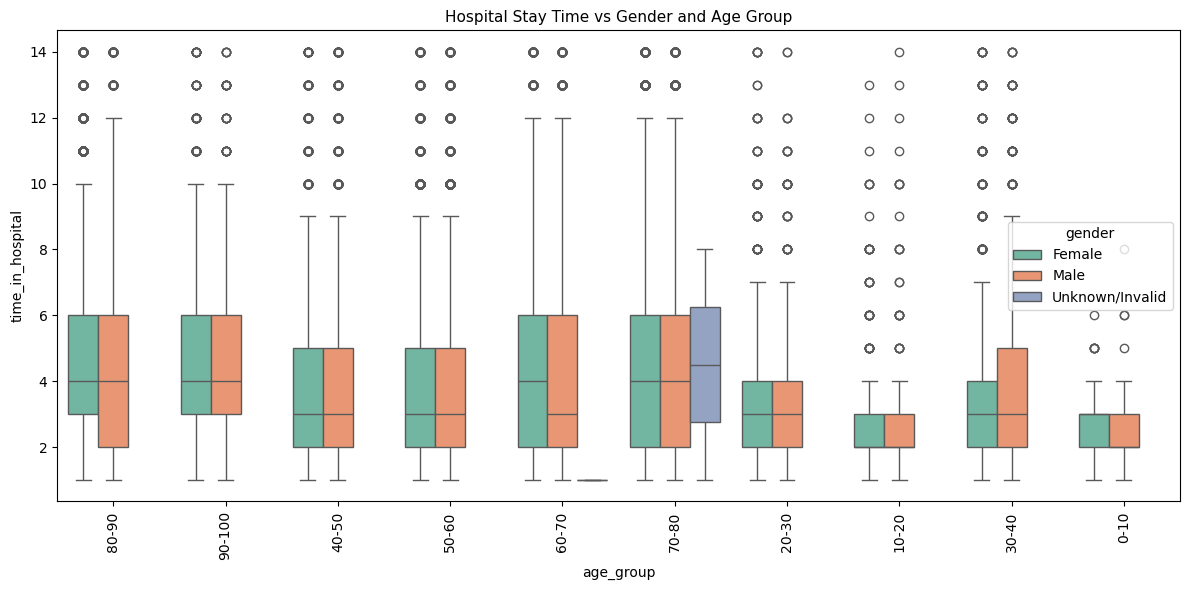

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


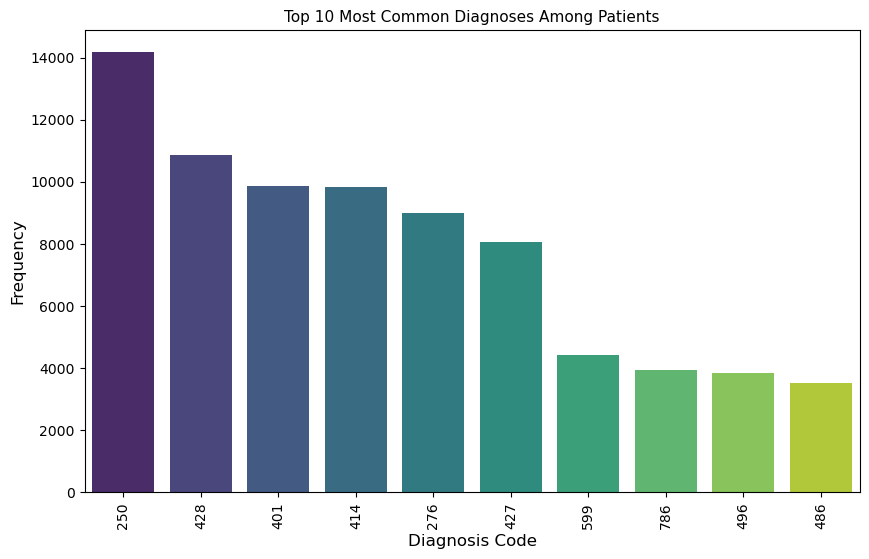

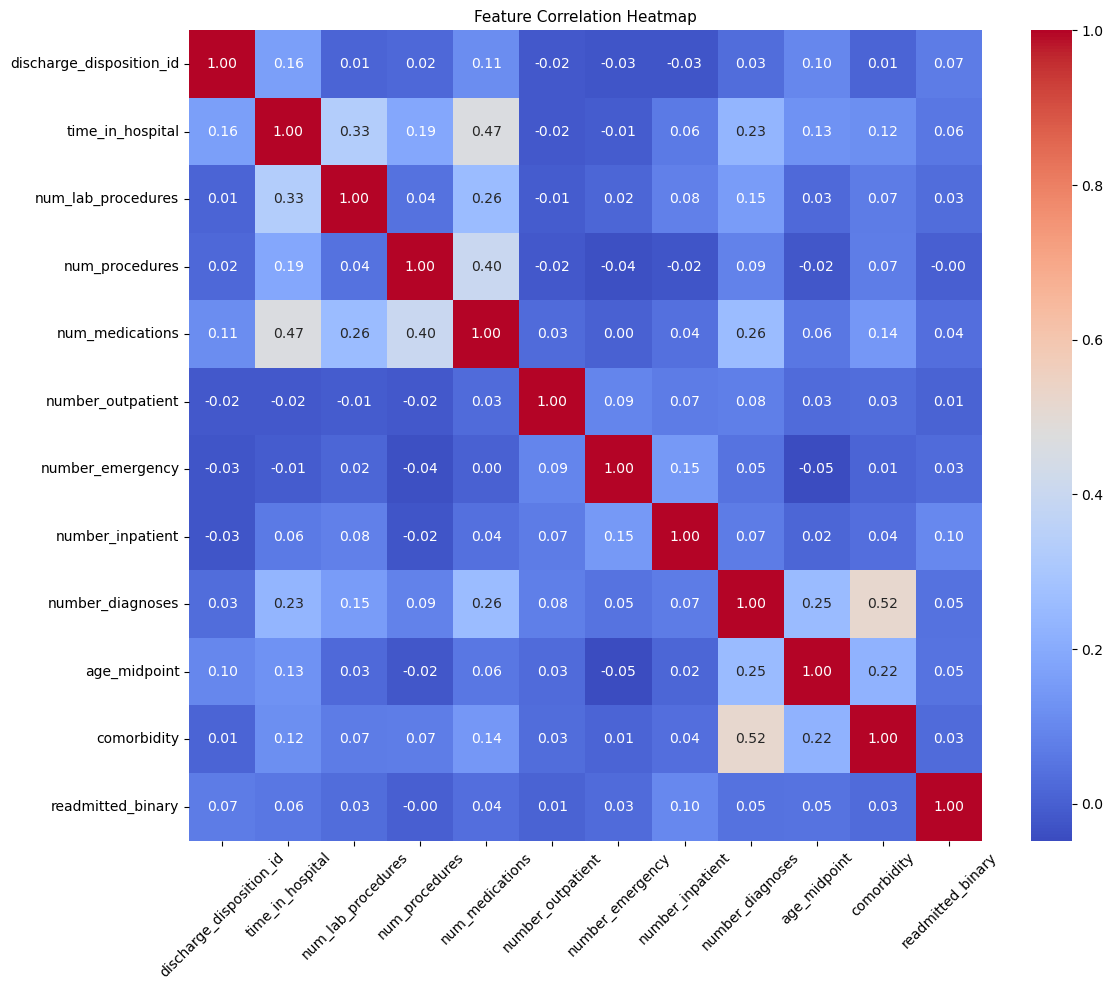

In [12]:
from eda_analyzer import EDAAnalyzer

# 选择你要分析的数据表
eda = EDAAnalyzer(df)  # 或 processed_data

# 1. readmission 分布
eda.plot_readmission_distribution()

# 2. 缺失值分布
eda.plot_missing_values()

# 1. 平均年龄
eda.plot_average_age()

# 2. 按年龄组画住院时长均值柱状图
eda.plot_avg_stay_by_age_group()

# 3. 按年龄组和性别画住院时长箱线图
eda.plot_avg_stay_by_age_gender_box()

# 4. 前10诊断分布
eda.plot_top_diagnoses_simple()

# 5. 特征相关性热力图
eda.plot_correlation_heatmap()


# 4. Medical interpretation

## 4.1 Readdmision rate with Age group & gender 

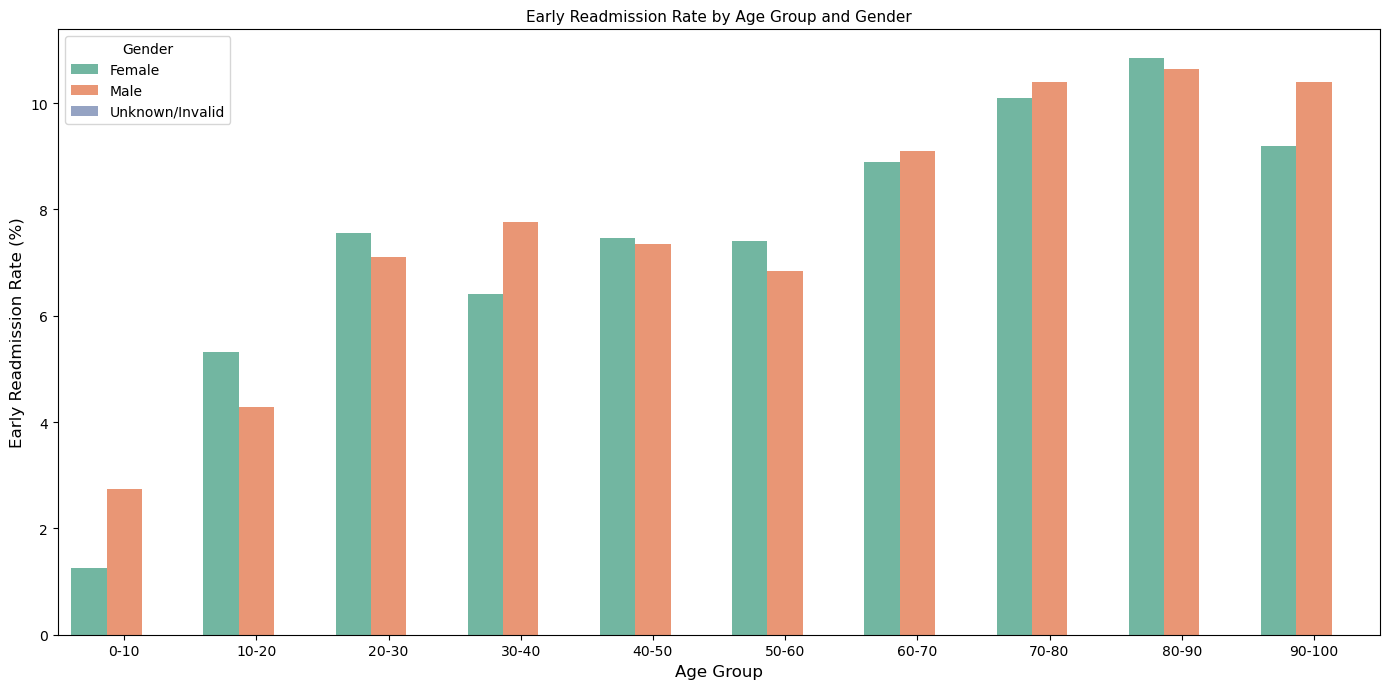

Readmission Rate Heatmap Table (age_group x gender_readmit):
gender_readmit  Early Readmission-Female  Early Readmission-Male  \
age_group                                                          
0-10                            0.653595                1.307190   
10-20                           2.996255                1.872659   
20-30                           4.906334                2.497770   
30-40                           3.714710                3.268945   
40-50                           3.661394                3.749268   
50-60                           3.595433                3.522552   
60-70                           4.342005                4.660801   
70-80                           5.419718                4.816901   
80-90                           6.638444                4.125383   
90-100                          6.534091                3.011364   

gender_readmit  No Early Readmission-Female  No Early Readmission-Male  
age_group                                        

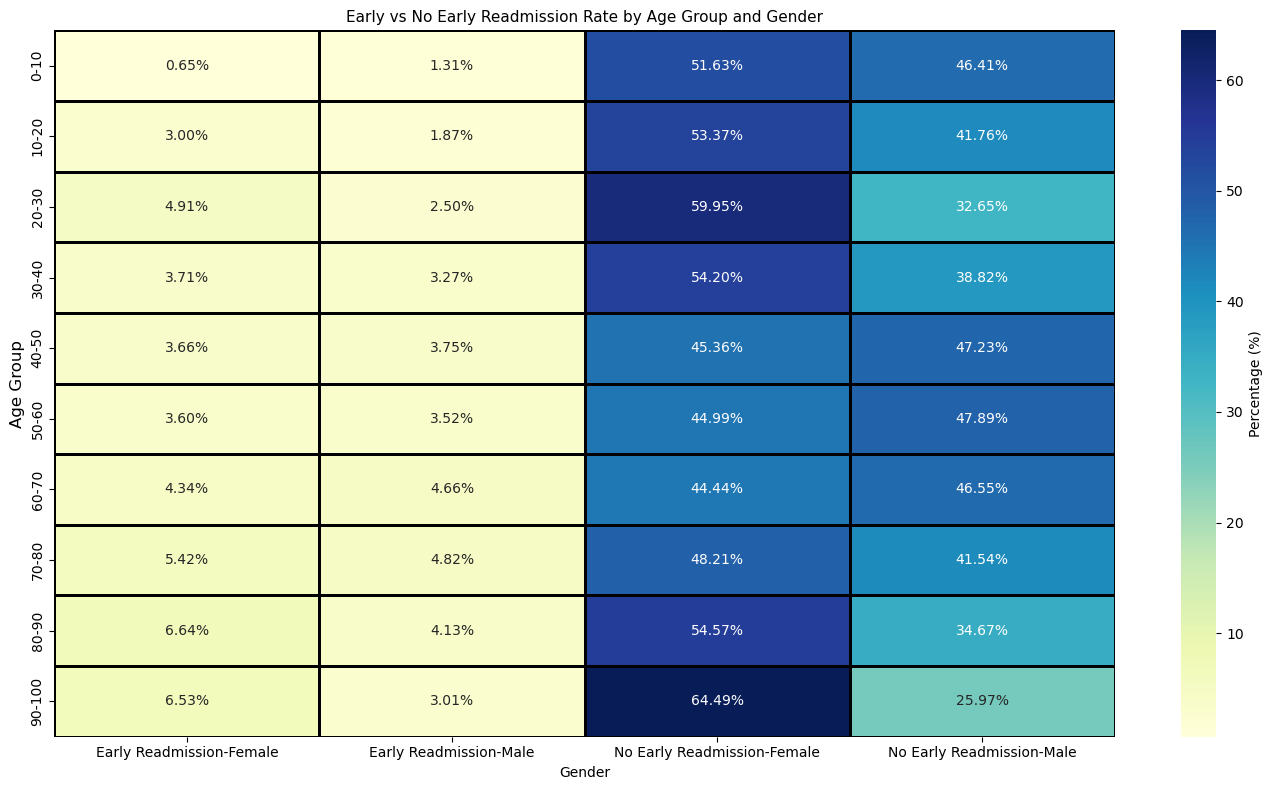

gender_readmit,Early Readmission-Female,Early Readmission-Male,No Early Readmission-Female,No Early Readmission-Male
age_group,,,,
0-10,0.653595,1.307190,51.633987,46.405229
10-20,2.996255,1.872659,53.370787,41.760300
20-30,4.906334,2.497770,59.946476,32.649420
30-40,3.714710,3.268945,54.197623,38.818722
40-50,3.661394,3.749268,45.357352,47.231986
50-60,3.595433,3.522552,44.991497,47.890517
60-70,4.342005,4.660801,44.440194,46.550625
70-80,5.419718,4.816901,48.208451,41.543662
80-90,6.638444,4.125383,54.566745,34.669429


In [13]:
# 统计并可视化不同年龄组和性别下的再入院率分布
eda.plot_readmission_rate_by_age_gender()

# 画age_group和gender下<30/>30 readmission rate的热力图
eda.plot_readmission_rate_heatmap_by_age_gender()



## 4.2  Relationship between comorbidities (e.g., diabetes, heart disease) and Readmission Rates

Readmission rate by comorbidity (%):
readmit_bin      Early Readmission Rate (%)  No Early Readmission Rate (%)
comorbidity                                                               
circulatory                        9.378063                      90.621937
diabetes                           8.632069                      91.367931
digestive                          8.563782                      91.436218
genitourinary                      8.841941                      91.158059
injuries                          10.224949                      89.775051
musculoskeletal                    8.102564                      91.897436
neoplasms                         12.936170                      87.063830
other                              8.088287                      91.911713
respiratory                        7.755406                      92.244594


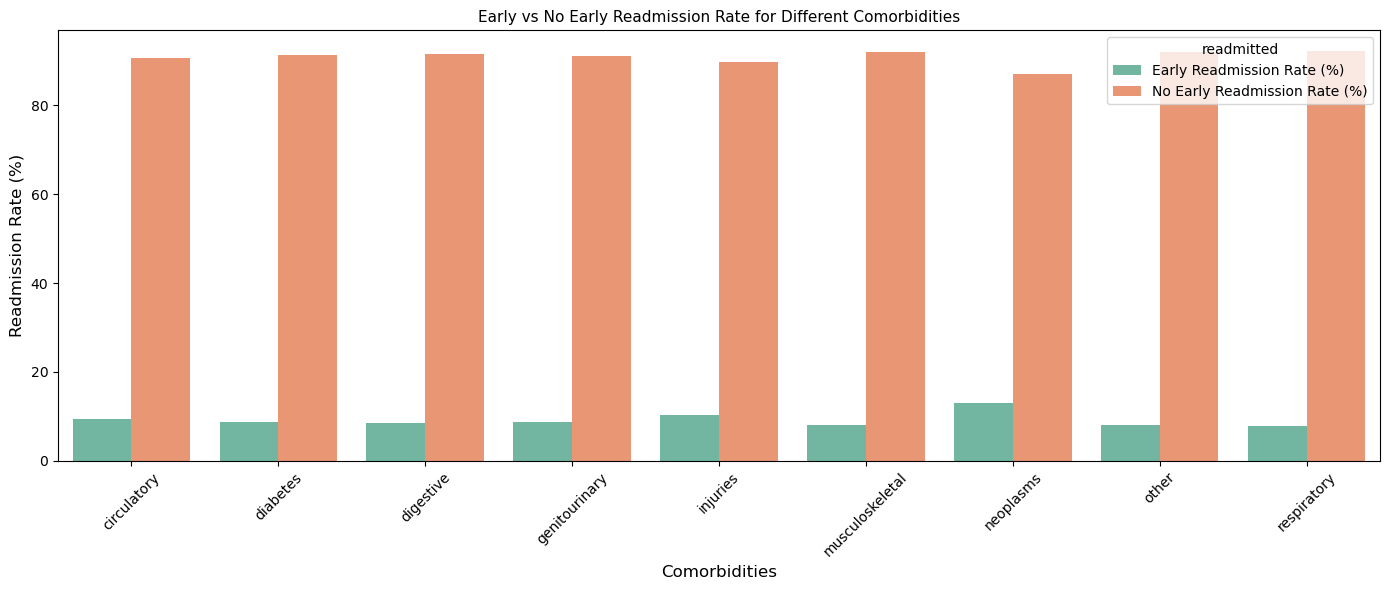

readmit_bin,comorbidity,Early Readmission Rate (%),No Early Readmission Rate (%)
0,circulatory,9.378063,90.621937
1,diabetes,8.632069,91.367931
2,digestive,8.563782,91.436218
3,genitourinary,8.841941,91.158059
4,injuries,10.224949,89.775051
5,musculoskeletal,8.102564,91.897436
6,neoplasms,12.936170,87.063830
7,other,8.088287,91.911713
8,respiratory,7.755406,92.244594


In [14]:
eda.plot_comorbidity_vs_readmission(preprocessor.icd9_to_nine_category)

## 4.3 Medication

Readmission Rate (<30 Days) by Medication & Dose Change:
readmitted           Medication Dose Change        <30
0                   glimepiride   Decreased  29.032258
1                   glimepiride   Increased  25.842697
2                   glimepiride   No Change  20.492397
3                   glimepiride   Not Given  22.075129
4                     glipizide   Decreased  25.945946
5                     glipizide   Increased  24.513619
6                     glipizide   No Change  21.662896
7                     glipizide   Not Given  22.021940
8           glipizide-metformin   No Change        NaN
9           glipizide-metformin   Not Given  22.028426
10                    glyburide   Decreased  20.833333
11                    glyburide   Increased  22.868217
12                    glyburide   No Change  22.475919
13                    glyburide   Not Given  21.975759
14          glyburide-metformin   Decreased        NaN
15          glyburide-metformin   Increased        NaN
16      

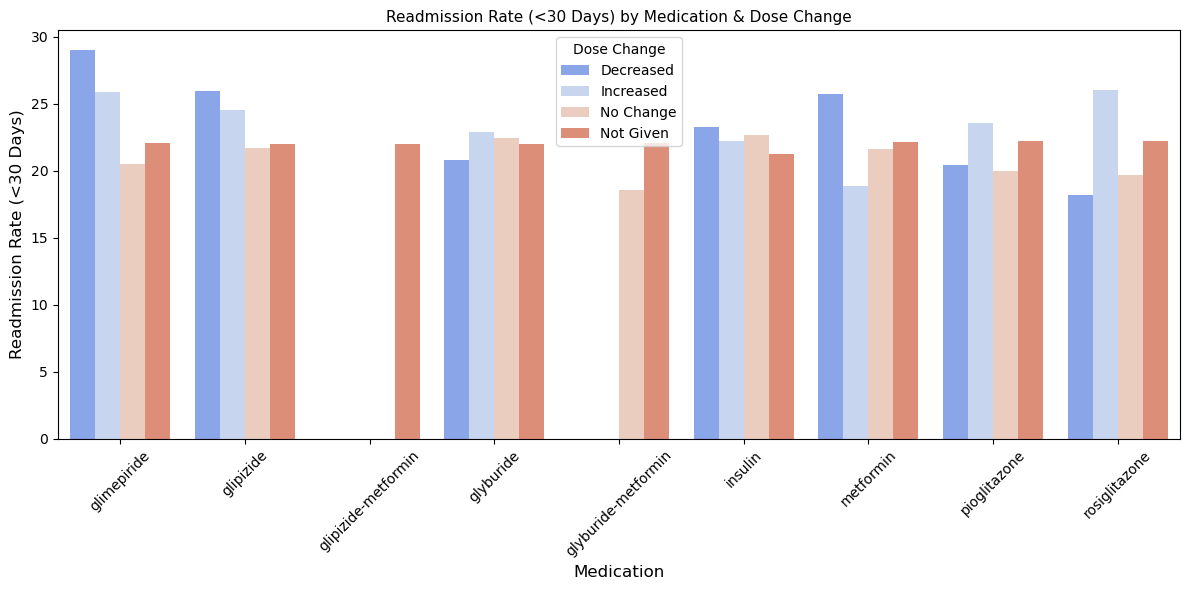

Readmission Rate (<30 Days) by Medication & Dose Change:
readmitted           Medication Dose Change        <30
0                   glimepiride   Decreased  29.032258
1                   glimepiride   Increased  25.842697
2                   glimepiride   No Change  20.492397
3                   glimepiride   Not Given  22.075129
4                     glipizide   Decreased  25.945946
5                     glipizide   Increased  24.513619
6                     glipizide   No Change  21.662896
7                     glipizide   Not Given  22.021940
8           glipizide-metformin   No Change        NaN
9           glipizide-metformin   Not Given  22.028426
10                    glyburide   Decreased  20.833333
11                    glyburide   Increased  22.868217
12                    glyburide   No Change  22.475919
13                    glyburide   Not Given  21.975759
14          glyburide-metformin   Decreased        NaN
15          glyburide-metformin   Increased        NaN
16      

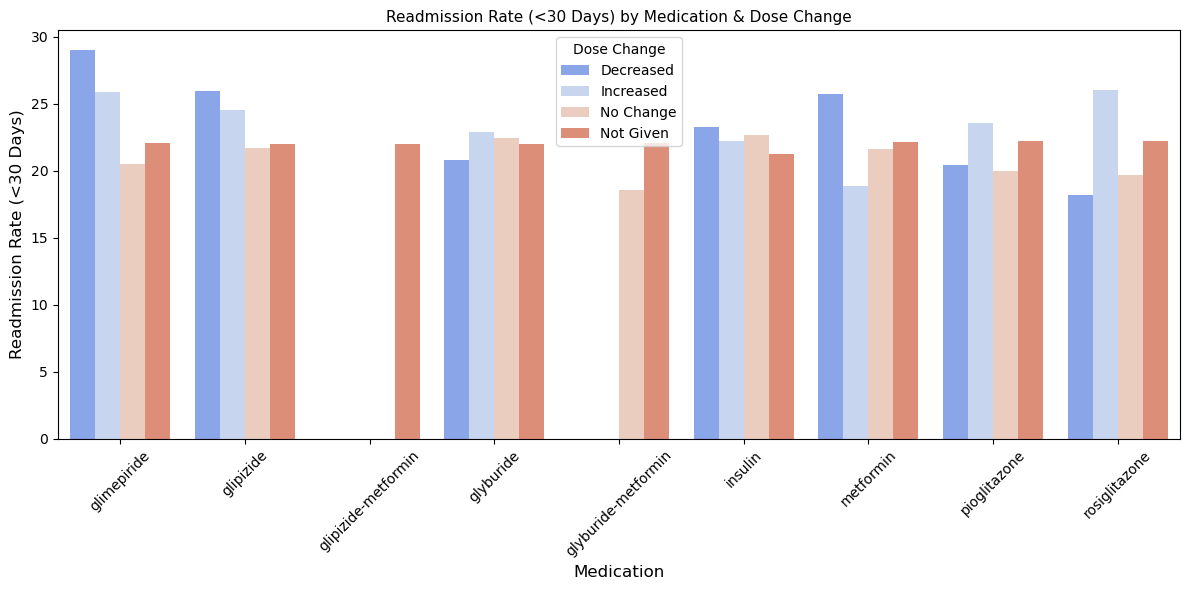

Readmission Rate (<30 Days) Heatmap Table:
Dose Change          Decreased  Increased  No Change  Not Given
Medication                                                     
glimepiride          29.032258  25.842697  20.492397  22.075129
glipizide            25.945946  24.513619  21.662896  22.021940
glipizide-metformin        NaN        NaN        NaN  22.028426
glyburide            20.833333  22.868217  22.475919  21.975759
glyburide-metformin        NaN        NaN  18.536585  22.048636
insulin              23.274043  22.196339  22.679361  21.244571
metformin            25.730994  18.831169  21.594368  22.140221
pioglitazone         20.454545  23.595506  19.990680  22.189169
rosiglitazone        18.181818  26.000000  19.669670  22.199099


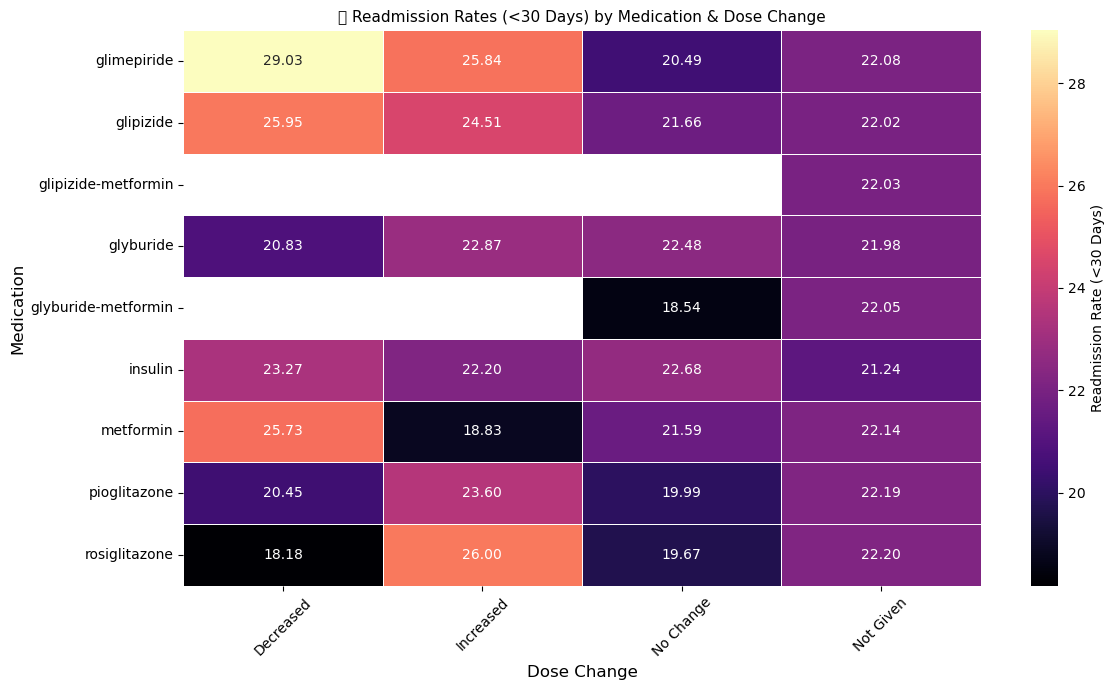

Dose Change,Decreased,Increased,No Change,Not Given
Medication,,,,
glimepiride,29.032258,25.842697,20.492397,22.075129
glipizide,25.945946,24.513619,21.662896,22.021940
glipizide-metformin,NaN,NaN,NaN,22.028426
glyburide,20.833333,22.868217,22.475919,21.975759
glyburide-metformin,NaN,NaN,18.536585,22.048636
insulin,23.274043,22.196339,22.679361,21.244571
metformin,25.730994,18.831169,21.594368,22.140221
pioglitazone,20.454545,23.595506,19.990680,22.189169
rosiglitazone,18.181818,26.000000,19.669670,22.199099


In [15]:


eda.plot_readmission_by_medication_and_dose()
# 热力图
eda.plot_readmission_by_medication_and_dose_heatmap()

# 5.Feature Engineering

## 5.1 Dataset division and encoding

In [16]:
# X_train, _, X_test, y_train, _, y_test = preprocessor.split_data(df)
# # 用X_test占位val参数
# X_train, _, X_test = preprocessor.encode_categorical_features(X_train, X_test, X_test)
# X_train, _, X_test = preprocessor.scale_numerical_features(X_train, X_test, X_test)

In [17]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocessor.split_data(df)
X_train, X_val, X_test = preprocessor.encode_categorical_features(X_train, X_val, X_test)
X_train, X_val, X_test = preprocessor.scale_numerical_features(X_train, X_val, X_test)
X_train_balanced, y_train_balanced = preprocessor.apply_smote(X_train, y_train)
print(f'The number of samples in the training set after balancing: {X_train_balanced.shape[0]}')

INFO:data_preprocessor:Splitting data into train/validation/test sets...
INFO:data_preprocessor:Dropping unused ID and target columns before splitting: ['encounter_id', 'patient_nbr', 'discharge_disposition_id', 'readmitted']
INFO:data_preprocessor:Data split - Train: (44782, 51), Val: (11196, 51), Test: (13995, 51)
INFO:data_preprocessor:Encoding categorical features using label encoding...
INFO:data_preprocessor:Scaling numerical features...
INFO:data_preprocessor:Applying SMOTE for class balancing...
INFO:data_preprocessor:Before SMOTE - Class distribution: {0: 40764, 1: 4018}
INFO:data_preprocessor:After SMOTE - Class distribution: {0: 40764, 1: 40764}


The number of samples in the training set after balancing: 81528


## 5.2 Top_N Feature selection

In [18]:
# ===============================================================
#          多Top N值特征选择与结果展示
# ===============================================================

# 1. 设置您想要测试的top_n值列表
top_n_list = [ 5,10,15]  # 您可以随意修改这个列表
print(f"将要测试的Top N值: {top_n_list}")

# 2. 创建特征选择器
selector = FeatureSelector()

# 3. 运行多个top_n值的特征选择
print("\n🚀 开始运行多个Top N值的特征选择...")
multiple_results = selector.select_features_multiple_topn(
    X_train_balanced, 
    y_train_balanced, 
    top_n_list
)
print("✅ 特征选择完成！")


from feature_selector import flatten_multiple_results
selected_features_dict = flatten_multiple_results(multiple_results)

# 5. (可选) 选择一组特征进行后续步骤
#    您可以根据上面的表格结果，选择一组最满意的特征
#    例如，选择top_n=10时，L1方法选择的特征
# ---------------------------------------------------------------
# chosen_top_n = 10
# chosen_method = 'L1'
# X_selected = X_train_balanced[multiple_results[chosen_top_n][chosen_method]]
# print(f"\n proceeding with top_n={chosen_top_n} and method='{chosen_method}'")
# print(f"Selected {len(X_selected.columns)} features.")

INFO:feature_selector:Running feature selection with multiple top_n values: [5, 10, 15]
INFO:feature_selector:Processing top_n = 5
INFO:feature_selector:Running all feature selection methods with top_n=5...
INFO:feature_selector:Selecting top 5 features using L1 regularization...


将要测试的Top N值: [5, 10, 15]

🚀 开始运行多个Top N值的特征选择...


INFO:feature_selector:L1 feature selection completed. Selected features: ['age_group', 'number_inpatient', 'tolazamide', 'diabetesMed', 'payer_code']
INFO:feature_selector:Selecting top 5 features using Mutual Information...
INFO:feature_selector:Mutual Information feature selection completed. Selected features: ['num_lab_procedures', 'num_medications', 'diag_3', 'diag_2', 'diag_1']
INFO:feature_selector:Selecting top 5 features using Tree-based importance...
INFO:feature_selector:Tree-based feature selection completed. Selected features: ['discharge_disposition_desc', 'age_midpoint', 'time_in_hospital', 'age', 'age_group']
INFO:feature_selector:All feature selection methods completed
INFO:feature_selector:Processing top_n = 10
INFO:feature_selector:Running all feature selection methods with top_n=10...
INFO:feature_selector:Selecting top 10 features using L1 regularization...
INFO:feature_selector:L1 feature selection completed. Selected features: ['age_group', 'number_inpatient', 'to

✅ 特征选择完成！


## 5.3 Feature selection visualization


📊 Multiple Top N Value Feature Selection Detailed Results:


,Top N,Method,Selected Features
0,5,L1,"[age_group, number_inpatient, tolazamide, diabetesMed, payer_code]"
1,5,MutualInfo,"[num_lab_procedures, num_medications, diag_3, diag_2, diag_1]"
2,5,TreeImportance,"[discharge_disposition_desc, age_midpoint, time_in_hospital, age, age_group]"
3,10,L1,"[age_group, number_inpatient, tolazamide, diabetesMed, payer_code, number_diagnoses, diag_1_category, time_in_hospital, num_procedures, admission_source_desc]"
4,10,MutualInfo,"[num_lab_procedures, num_medications, diag_3, diag_2, diag_1, time_in_hospital, number_diagnoses, age_group, num_procedures, age_midpoint]"
5,10,TreeImportance,"[discharge_disposition_desc, age_midpoint, time_in_hospital, age, age_group, num_procedures, admission_source_desc, diag_3, number_diagnoses, diag_3_category]"
6,15,L1,"[age_group, number_inpatient, tolazamide, diabetesMed, payer_code, number_diagnoses, diag_1_category, time_in_hospital, num_procedures, admission_source_desc, discharge_disposition_desc, metformin, medical_specialty, glipizide-metformin, chlorpropamide]"
7,15,MutualInfo,"[num_lab_procedures, num_medications, diag_3, diag_2, diag_1, time_in_hospital, number_diagnoses, age_group, num_procedures, age_midpoint, age, diag_1_category, diag_3_category, diag_2_category, medical_specialty]"
8,15,TreeImportance,"[discharge_disposition_desc, age_midpoint, time_in_hospital, age, age_group, num_procedures, admission_source_desc, diag_3, number_diagnoses, diag_3_category, admission_type_desc, diag_1, diag_2, diag_1_category, num_medications]"


INFO:feature_selector:Found 1 features selected by at least 2 methods
INFO:feature_selector:Found 0 features selected by at least 3 methods
INFO:feature_selector:Found 7 features selected by at least 2 methods
INFO:feature_selector:Found 4 features selected by at least 3 methods
INFO:feature_selector:Found 15 features selected by at least 2 methods
INFO:feature_selector:Found 5 features selected by at least 3 methods



🔍 Common Features Summary by Top N Value:


,Top N,Common Features (>=2 methods),Common Features (all 3 methods)
0,5,[age_group],[]
1,10,"[age_group, number_diagnoses, time_in_hospital, num_procedures, admission_source_desc, diag_3, age_midpoint]","[age_group, number_diagnoses, time_in_hospital, num_procedures]"
2,15,"[age_group, number_diagnoses, diag_1_category, time_in_hospital, num_procedures, admission_source_desc, discharge_disposition_desc, medical_specialty, num_medications, diag_3, diag_2, diag_1, age_midpoint, age, diag_3_category]","[age_group, number_diagnoses, diag_1_category, time_in_hospital, num_procedures]"



🎨 Generating Feature Selection Matrix Visualization Chart:


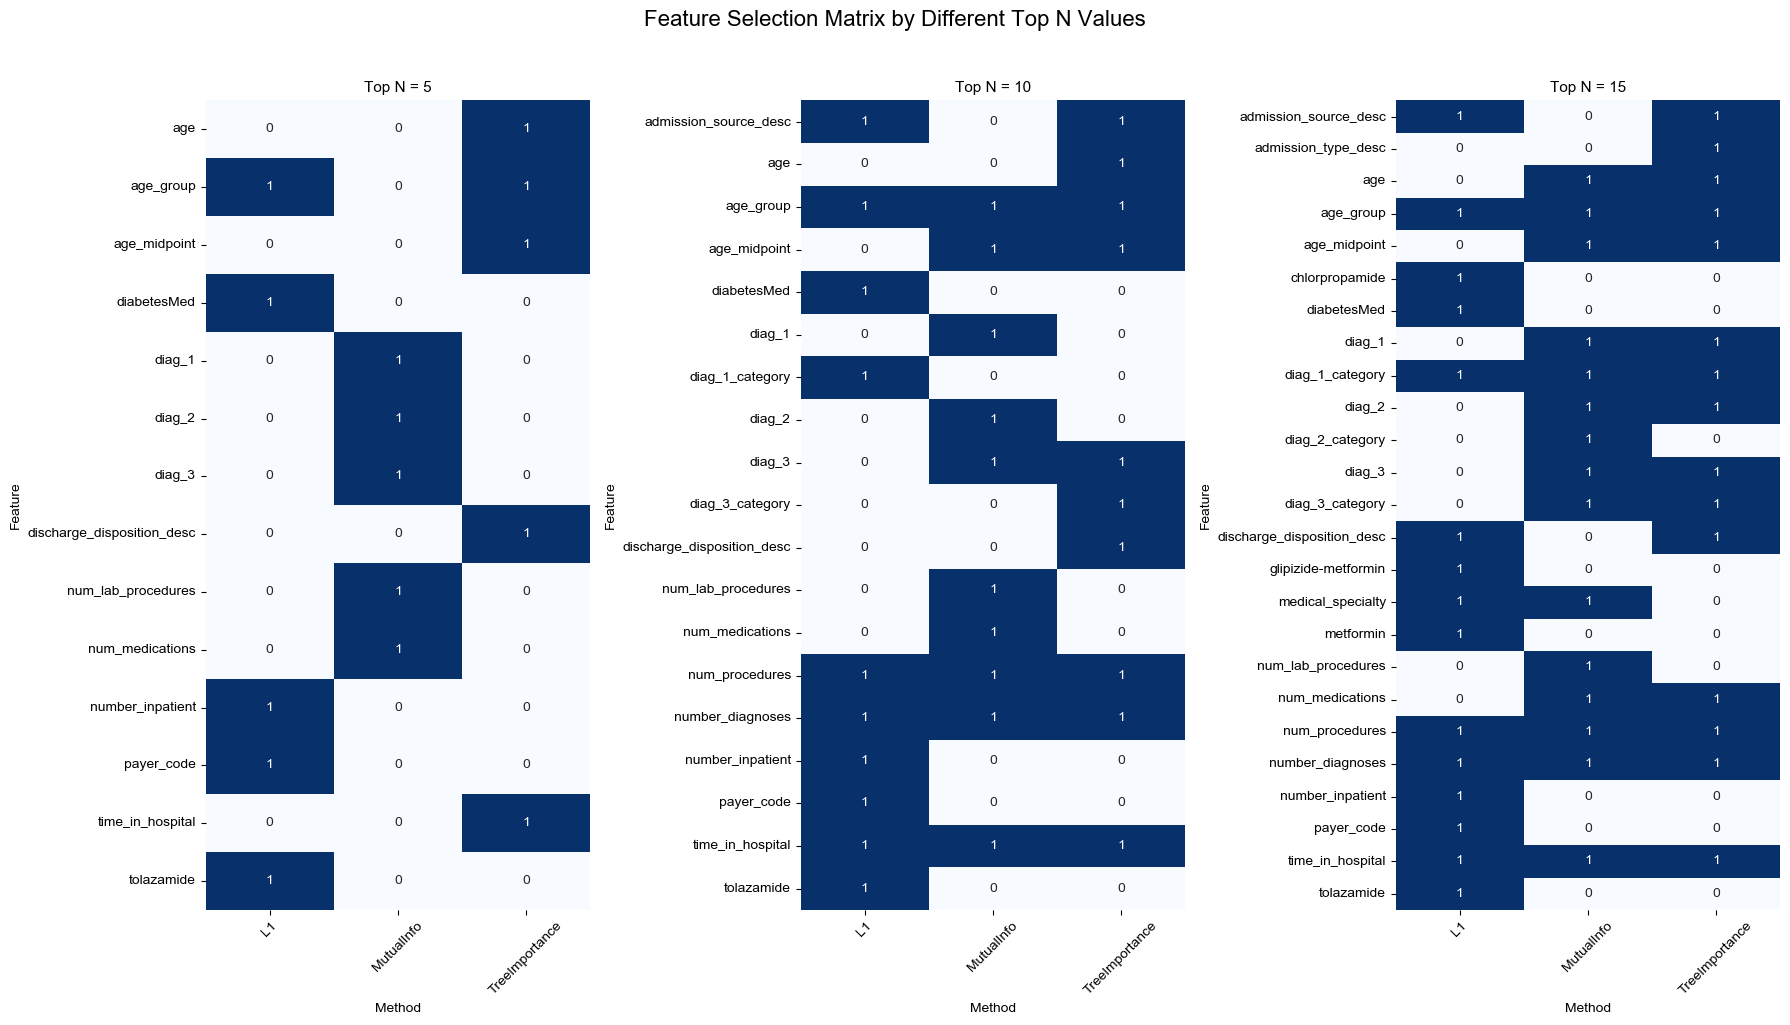

In [19]:
pd.set_option('display.max_colwidth', None)  # 不限制列宽
pd.set_option('display.max_columns', None)   # 显示所有列
pd.set_option('display.width', None)         # 不限制显示宽度

# 4. 以表格形式显示结果
selector.display_multiple_topn_results(multiple_results)

# 5. [新增] 可视化特征选择矩阵
selector.plot_feature_selection_matrix(multiple_results)

# ============

SUMMARY TABLE - All Features vs Top N Values

📋 Feature Selection Summary Table (All Features)
1 = Selected in at least one method for this Top N
0 = Not selected for this Top N


,Feature,Top N=5,Top N=10,Top N=15
0,admission_source_desc,1,1,1
1,admission_type_desc,1,1,1
2,age,1,1,1
3,age_group,1,1,1
4,age_midpoint,1,1,1
5,chlorpropamide,1,1,1
6,diabetesMed,1,1,1
7,diag_1,1,1,1
8,diag_1_category,1,1,1
9,diag_2,1,1,1



📊 Summary Statistics:
Total unique features: 25
Features selected in Top N=5: 25 (100.0%)
Features selected in Top N=10: 25 (100.0%)
Features selected in Top N=15: 25 (100.0%)

DETAILED TABLE - All Features vs Method & Top N Values

📋 Detailed Feature Selection Table (By Method)
1 = Selected by this method for this Top N
0 = Not selected by this method for this Top N


,Feature,Top5_L1,Top5_MutualInfo,Top5_TreeImportance,Top10_L1,Top10_MutualInfo,Top10_TreeImportance,Top15_L1,Top15_MutualInfo,Top15_TreeImportance
0,admission_source_desc,0,0,0,1,0,1,1,0,1
1,admission_type_desc,0,0,0,0,0,0,0,0,1
2,age,0,0,1,0,0,1,0,1,1
3,age_group,1,0,1,1,1,1,1,1,1
4,age_midpoint,0,0,1,0,1,1,0,1,1
5,chlorpropamide,0,0,0,0,0,0,1,0,0
6,diabetesMed,1,0,0,1,0,0,1,0,0
7,diag_1,0,1,0,0,1,0,0,1,1
8,diag_1_category,0,0,0,1,0,0,1,1,1
9,diag_2,0,1,0,0,1,0,0,1,1



📊 Detailed Statistics:
Total unique features: 25
Feature selection methods: L1, MutualInfo, TreeImportance

Top N=5:
  L1: 5 features (20.0%)
  MutualInfo: 5 features (20.0%)
  TreeImportance: 5 features (20.0%)

Top N=10:
  L1: 10 features (40.0%)
  MutualInfo: 10 features (40.0%)
  TreeImportance: 10 features (40.0%)

Top N=15:
  L1: 15 features (60.0%)
  MutualInfo: 15 features (60.0%)
  TreeImportance: 15 features (60.0%)

📊 Multiple Top N Value Feature Selection Detailed Results:


,Top N,Method,Selected Features
0,5,L1,"[age_group, number_inpatient, tolazamide, diabetesMed, payer_code]"
1,5,MutualInfo,"[num_lab_procedures, num_medications, diag_3, diag_2, diag_1]"
2,5,TreeImportance,"[discharge_disposition_desc, age_midpoint, time_in_hospital, age, age_group]"
3,10,L1,"[age_group, number_inpatient, tolazamide, diabetesMed, payer_code, number_diagnoses, diag_1_category, time_in_hospital, num_procedures, admission_source_desc]"
4,10,MutualInfo,"[num_lab_procedures, num_medications, diag_3, diag_2, diag_1, time_in_hospital, number_diagnoses, age_group, num_procedures, age_midpoint]"
5,10,TreeImportance,"[discharge_disposition_desc, age_midpoint, time_in_hospital, age, age_group, num_procedures, admission_source_desc, diag_3, number_diagnoses, diag_3_category]"
6,15,L1,"[age_group, number_inpatient, tolazamide, diabetesMed, payer_code, number_diagnoses, diag_1_category, time_in_hospital, num_procedures, admission_source_desc, discharge_disposition_desc, metformin, medical_specialty, glipizide-metformin, chlorpropamide]"
7,15,MutualInfo,"[num_lab_procedures, num_medications, diag_3, diag_2, diag_1, time_in_hospital, number_diagnoses, age_group, num_procedures, age_midpoint, age, diag_1_category, diag_3_category, diag_2_category, medical_specialty]"
8,15,TreeImportance,"[discharge_disposition_desc, age_midpoint, time_in_hospital, age, age_group, num_procedures, admission_source_desc, diag_3, number_diagnoses, diag_3_category, admission_type_desc, diag_1, diag_2, diag_1_category, num_medications]"


INFO:feature_selector:Found 1 features selected by at least 2 methods
INFO:feature_selector:Found 0 features selected by at least 3 methods
INFO:feature_selector:Found 7 features selected by at least 2 methods
INFO:feature_selector:Found 4 features selected by at least 3 methods
INFO:feature_selector:Found 15 features selected by at least 2 methods
INFO:feature_selector:Found 5 features selected by at least 3 methods



🔍 Common Features Summary by Top N Value:


,Top N,Common Features (>=2 methods),Common Features (all 3 methods)
0,5,[age_group],[]
1,10,"[age_group, number_diagnoses, time_in_hospital, num_procedures, admission_source_desc, diag_3, age_midpoint]","[age_group, number_diagnoses, time_in_hospital, num_procedures]"
2,15,"[age_group, number_diagnoses, diag_1_category, time_in_hospital, num_procedures, admission_source_desc, discharge_disposition_desc, medical_specialty, num_medications, diag_3, diag_2, diag_1, age_midpoint, age, diag_3_category]","[age_group, number_diagnoses, diag_1_category, time_in_hospital, num_procedures]"



🎨 Generating Feature Selection Matrix Visualization Chart:


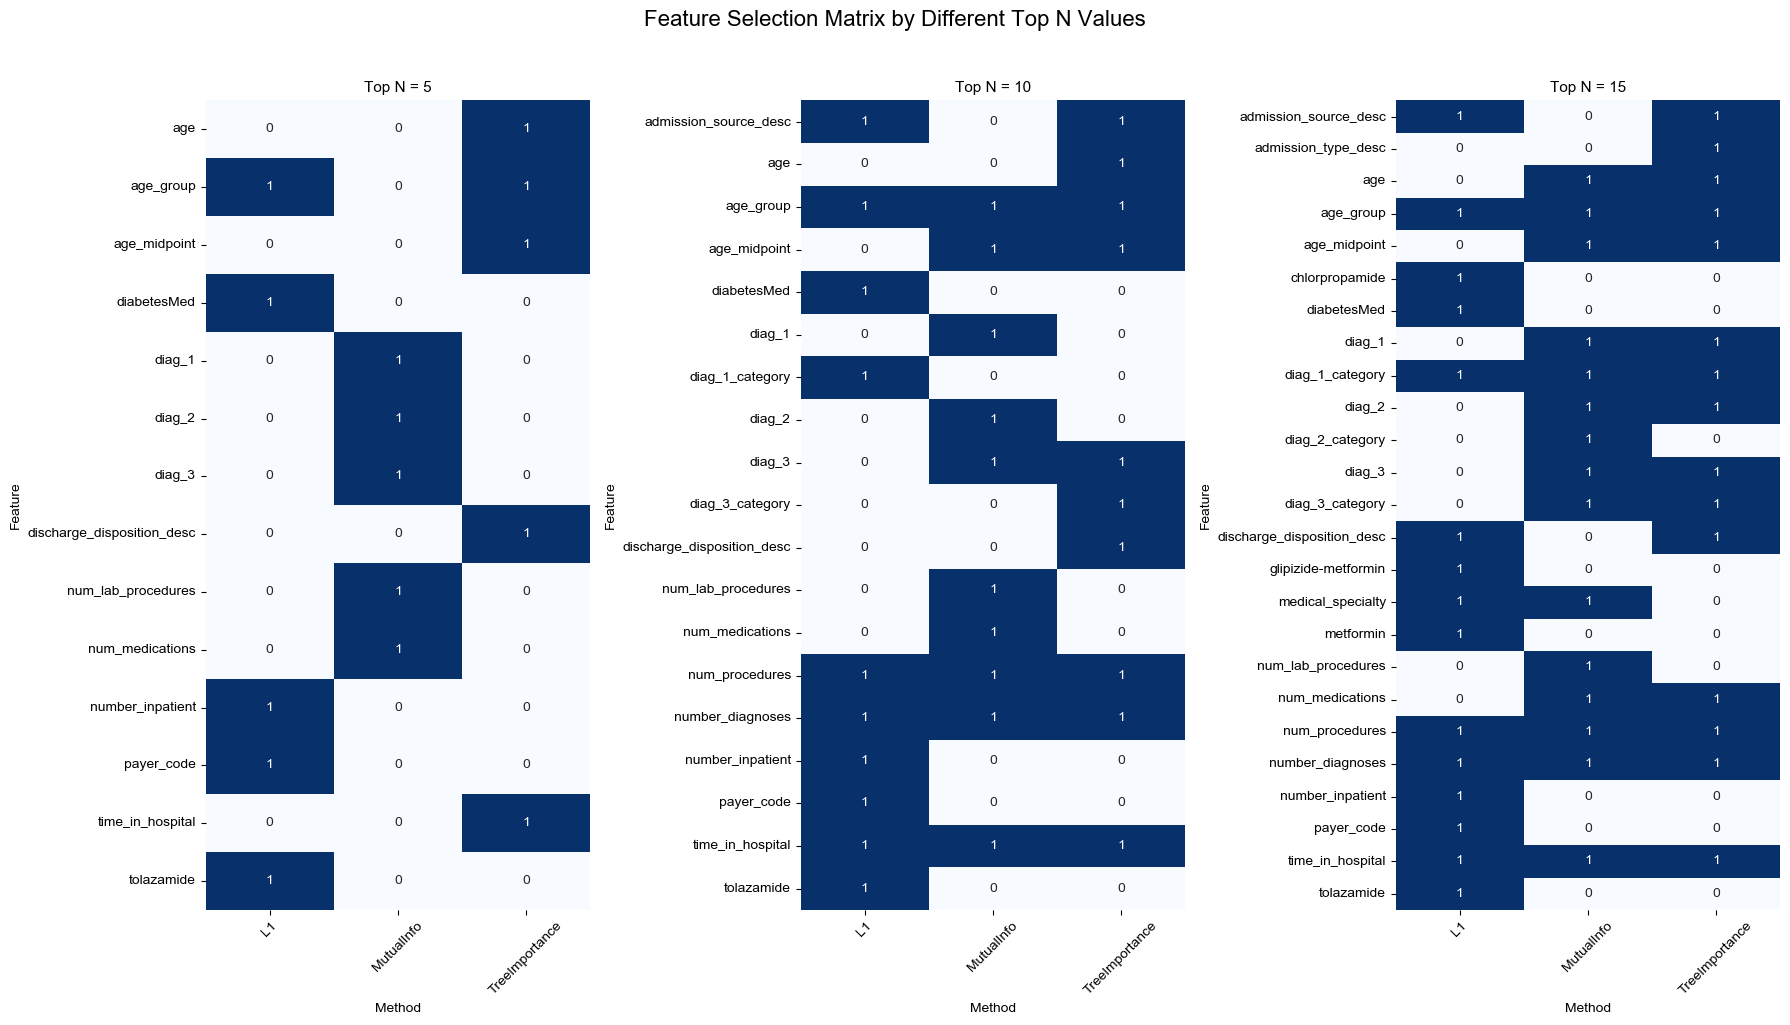

In [20]:
# 设置pandas显示选项
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# 4. 显示汇总表格（你想要的格式）
print("=" * 60)
print("SUMMARY TABLE - All Features vs Top N Values")
print("=" * 60)
summary_df = selector.display_feature_selection_summary_table(multiple_results)

# 5. 显示详细表格（按方法分别显示）
print("\n" + "=" * 60)
print("DETAILED TABLE - All Features vs Method & Top N Values")
print("=" * 60)
detailed_df = selector.display_detailed_feature_selection_table(multiple_results)

# 6. 原有的表格和可视化
selector.display_multiple_topn_results(multiple_results)
selector.plot_feature_selection_matrix(multiple_results)

# 6. Model training and evaluation

In [21]:
# here is the defalt setting of model taining
# # 查阅model_trainer.py的get_models()方法，你当前的模型参数是默认的，具体如下：
# •	LogisticRegression:
# •	solver='liblinear'
# •	random_state=42
# •	其余参数默认（如C=1.0）
# •	RandomForestClassifier:
# •	n_estimators=100
# •	random_state=42
# •	其余参数默认（如max_depth=None）
# •	XGBoost (XGBClassifier):
# •	eval_metric='logloss'
# •	random_state=42
# •	其余参数默认（如n_estimators=100, learning_rate=0.3）
# 没有做超参数调优（grid search），只是用了一组固定参数。


# feature_selectors = selector.get_feature_selectors() 

# feature_sets = {}
# for top_n in top_n_list:
#     feature_sets[top_n] = {}
#     for fs_name, fs_func in feature_selectors.items():
#         features = fs_func(X_train_balanced, y_train_balanced, top_n=top_n)
#         feature_sets[top_n][fs_name] = features
           
# model_trainer = ModelTrainer()
# results_df = model_trainer.evaluate_all_combinations_on_val_and_test(
#     feature_sets, X_train, y_train, X_val, y_val, X_test, y_test
# )
# display(results_df)


In [22]:
print(df.columns)

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'discharge_disposition_id', 'time_in_hospital', 'payer_code',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'admission_type_desc', 'discharge_disposition_desc',
       'admission_source_desc', 'age_midpoint', 'age_group', 'diag_1_category',
       'diag_2_category', 'diag_3_category'

In [50]:
# 导入必要的包
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import pandas as pd
import os

# 设置参数（这些保留在notebook中便于修改）
fs_names = ['L1', 'MutualInfo', 'TreeImportance']
top_n = 5
cv_folds = 5  # 可以改成5

# 定义模型和参数网格
model_classes = {
    'RandomForest': RandomForestClassifier,
    'LogisticRegression': LogisticRegression,
    'XGBoost': XGBClassifier
}

# default 
param_grids = {
    'RandomForest': {'n_estimators': [100, 300], 'max_depth': [5, 10,20]},
    'LogisticRegression': {'C': [0.1, 1, 10,100], 'solver': ['liblinear']},
    'XGBoost': {'n_estimators': [100, 300], 'learning_rate': [ 0.1,0.2]}
}


In [51]:

# 调用py文件中的方法
model_trainer = ModelTrainer()
all_val_results, all_test_results, all_cv_results_list = model_trainer.run_grid_search_for_all_fs_methods(
    fs_names=fs_names,
    top_n=top_n,
    selected_features_dict=selected_features_dict,
    model_classes=model_classes,
    param_grids=param_grids,
    X_train_balanced=X_train_balanced,
    y_train_balanced=y_train_balanced,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    cv_folds=cv_folds
)

# 保存到Excel（这部分保留在notebook中便于修改）
excel_path = '0720_5_all_param_search_results_gridcv final_cv5.xlsx'
mode = 'a' if os.path.exists(excel_path) else 'w'

with pd.ExcelWriter(excel_path, mode=mode, if_sheet_exists='replace' if mode=='a' else None) as writer:
    for i, fs_name in enumerate(fs_names):
        val_df = all_val_results[i]
        test_df = all_test_results[i]
        cv_df = all_cv_results_list[i]
        
        val_df.to_excel(writer, sheet_name=f'{fs_name}_val', index=False)
        test_df.to_excel(writer, sheet_name=f'{fs_name}_test', index=False)
        cv_df.to_excel(writer, sheet_name=f'{fs_name}_cv', index=False)
        
        print(f"{fs_name} 结果已保存到 {excel_path}")

print("所有GridSearchCV结果已保存完成！")


Grid search for L1 - RandomForest ...
Best params: {'max_depth': 20, 'n_estimators': 300}

Grid search for L1 - LogisticRegression ...
Best params: {'C': 0.1, 'solver': 'liblinear'}

Grid search for L1 - XGBoost ...
Best params: {'learning_rate': 0.2, 'n_estimators': 100}
L1 GridSearchCV completed

Grid search for MutualInfo - RandomForest ...
Best params: {'max_depth': 20, 'n_estimators': 300}

Grid search for MutualInfo - LogisticRegression ...
Best params: {'C': 0.1, 'solver': 'liblinear'}

Grid search for MutualInfo - XGBoost ...
Best params: {'learning_rate': 0.2, 'n_estimators': 300}
MutualInfo GridSearchCV completed

Grid search for TreeImportance - RandomForest ...
Best params: {'max_depth': 20, 'n_estimators': 300}

Grid search for TreeImportance - LogisticRegression ...
Best params: {'C': 10, 'solver': 'liblinear'}

Grid search for TreeImportance - XGBoost ...
Best params: {'learning_rate': 0.1, 'n_estimators': 100}
TreeImportance GridSearchCV completed
L1 结果已保存到 0720_5_all_

## L1

In [52]:
# # 原型代码，循环

# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import roc_auc_score, f1_score
# import pandas as pd
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from xgboost import XGBClassifier
# import os

# fs_name = 'L1'  # 或 'MutualInfo', 'TreeImportance'
# top_n = 15
# feature_list = selected_features_dict[(top_n, fs_name)]



# val_results = []
# test_results = []
# all_cv_results_list = []

# for model_name, model_cls in model_classes.items():
#     print(f"\nGrid search for {model_name} ...")
#     grid = GridSearchCV(
#         estimator=model_cls(),
#         param_grid=param_grids[model_name],
#         scoring='roc_auc',
#         cv=3,  # 你可以改成5
#         n_jobs=-1,
#         return_train_score=False
#     )
#     grid.fit(X_train_balanced[feature_list], y_train_balanced)
#     best_params = grid.best_params_
#     print("Best params:", best_params)
#     all_cv_results = pd.DataFrame(grid.cv_results_)
#     all_cv_results['model'] = model_name
#     all_cv_results['fs'] = fs_name
#     all_cv_results['top_n'] = top_n
#     all_cv_results_list.append(all_cv_results)
#     y_val_pred = grid.best_estimator_.predict(X_val[feature_list])
#     y_val_prob = grid.best_estimator_.predict_proba(X_val[feature_list])[:, 1]
#     val_auc = roc_auc_score(y_val, y_val_prob)
#     val_f1 = f1_score(y_val, y_val_pred)
#     val_results.append({
#         'model': model_name,
#         'fs': fs_name,
#         'top_n': top_n,
#         **best_params,
#         'val_auc': val_auc,
#         'val_f1': val_f1
#     })
#     y_test_pred = grid.best_estimator_.predict(X_test[feature_list])
#     y_test_prob = grid.best_estimator_.predict_proba(X_test[feature_list])[:, 1]
#     test_auc = roc_auc_score(y_test, y_test_prob)
#     test_f1 = f1_score(y_test, y_test_pred)
#     test_results.append({
#         'model': model_name,
#         'fs': fs_name,
#         'top_n': top_n,
#         **best_params,
#         'test_auc': test_auc,
#         'test_f1': test_f1
#     })


# val_df = pd.DataFrame(val_results)
# test_df = pd.DataFrame(test_results)
# all_cv_results_df = pd.concat(all_cv_results_list, ignore_index=True)

# excel_path = 'all_param_search_results_gridcv.xlsx'
# mode = 'a' if os.path.exists(excel_path) else 'w'
# with pd.ExcelWriter(excel_path, mode=mode, if_sheet_exists='replace' if mode=='a' else None) as writer:
#     val_df.to_excel(writer, sheet_name=f'{fs_name}_val', index=False)
#     test_df.to_excel(writer, sheet_name=f'{fs_name}_test', index=False)
#     all_cv_results_df.to_excel(writer, sheet_name=f'{fs_name}_cv', index=False)

# print(f"GridSearchCV所有参数组合、val和test最优结果已保存到 {excel_path} 的 sheet: {fs_name}_cv, {fs_name}_val, {fs_name}_test")

## MutualInfo

In [53]:
# # 原型代码，循环

# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import roc_auc_score, f1_score
# import pandas as pd
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from xgboost import XGBClassifier
# import os

# fs_name = 'MutualInfo'  # 或 'MutualInfo', 'TreeImportance'
# top_n = 15
# feature_list = selected_features_dict[(top_n, fs_name)]



# val_results = []
# test_results = []
# all_cv_results_list = []

# for model_name, model_cls in model_classes.items():
#     print(f"\nGrid search for {model_name} ...")
#     grid = GridSearchCV(
#         estimator=model_cls(),
#         param_grid=param_grids[model_name],
#         scoring='roc_auc',
#         cv=3,  # 你可以改成5
#         n_jobs=-1,
#         return_train_score=False
#     )
#     grid.fit(X_train_balanced[feature_list], y_train_balanced)
#     best_params = grid.best_params_
#     print("Best params:", best_params)
#     all_cv_results = pd.DataFrame(grid.cv_results_)
#     all_cv_results['model'] = model_name
#     all_cv_results['fs'] = fs_name
#     all_cv_results['top_n'] = top_n
#     all_cv_results_list.append(all_cv_results)
#     y_val_pred = grid.best_estimator_.predict(X_val[feature_list])
#     y_val_prob = grid.best_estimator_.predict_proba(X_val[feature_list])[:, 1]
#     val_auc = roc_auc_score(y_val, y_val_prob)
#     val_f1 = f1_score(y_val, y_val_pred)
#     val_results.append({
#         'model': model_name,
#         'fs': fs_name,
#         'top_n': top_n,
#         **best_params,
#         'val_auc': val_auc,
#         'val_f1': val_f1
#     })
#     y_test_pred = grid.best_estimator_.predict(X_test[feature_list])
#     y_test_prob = grid.best_estimator_.predict_proba(X_test[feature_list])[:, 1]
#     test_auc = roc_auc_score(y_test, y_test_prob)
#     test_f1 = f1_score(y_test, y_test_pred)
#     test_results.append({
#         'model': model_name,
#         'fs': fs_name,
#         'top_n': top_n,
#         **best_params,
#         'test_auc': test_auc,
#         'test_f1': test_f1
#     })


# val_df = pd.DataFrame(val_results)
# test_df = pd.DataFrame(test_results)
# all_cv_results_df = pd.concat(all_cv_results_list, ignore_index=True)

# excel_path = 'all_param_search_results_gridcv.xlsx'
# mode = 'a' if os.path.exists(excel_path) else 'w'
# with pd.ExcelWriter(excel_path, mode=mode, if_sheet_exists='replace' if mode=='a' else None) as writer:
#     val_df.to_excel(writer, sheet_name=f'{fs_name}_val', index=False)
#     test_df.to_excel(writer, sheet_name=f'{fs_name}_test', index=False)
#     all_cv_results_df.to_excel(writer, sheet_name=f'{fs_name}_cv', index=False)

# print(f"GridSearchCV所有参数组合、val和test最优结果已保存到 {excel_path} 的 sheet: {fs_name}_cv, {fs_name}_val, {fs_name}_test")

## TreeImportance

In [54]:
# # 原型代码，循环

# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import roc_auc_score, f1_score
# import pandas as pd
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from xgboost import XGBClassifier
# import os

# fs_name = 'TreeImportance'  # 或 'MutualInfo', 'TreeImportance'
# top_n = 15
# feature_list = selected_features_dict[(top_n, fs_name)]



# val_results = []
# test_results = []
# all_cv_results_list = []

# for model_name, model_cls in model_classes.items():
#     print(f"\nGrid search for {model_name} ...")
#     grid = GridSearchCV(
#         estimator=model_cls(),
#         param_grid=param_grids[model_name],
#         scoring='roc_auc',
#         cv=3,  # 你可以改成5
#         n_jobs=-1,
#         return_train_score=False
#     )
#     grid.fit(X_train_balanced[feature_list], y_train_balanced)
#     best_params = grid.best_params_
#     print("Best params:", best_params)
#     all_cv_results = pd.DataFrame(grid.cv_results_)
#     all_cv_results['model'] = model_name
#     all_cv_results['fs'] = fs_name
#     all_cv_results['top_n'] = top_n
#     all_cv_results_list.append(all_cv_results)
#     y_val_pred = grid.best_estimator_.predict(X_val[feature_list])
#     y_val_prob = grid.best_estimator_.predict_proba(X_val[feature_list])[:, 1]
#     val_auc = roc_auc_score(y_val, y_val_prob)
#     val_f1 = f1_score(y_val, y_val_pred)
#     val_results.append({
#         'model': model_name,
#         'fs': fs_name,
#         'top_n': top_n,
#         **best_params,
#         'val_auc': val_auc,
#         'val_f1': val_f1
#     })
#     y_test_pred = grid.best_estimator_.predict(X_test[feature_list])
#     y_test_prob = grid.best_estimator_.predict_proba(X_test[feature_list])[:, 1]
#     test_auc = roc_auc_score(y_test, y_test_prob)
#     test_f1 = f1_score(y_test, y_test_pred)
#     test_results.append({
#         'model': model_name,
#         'fs': fs_name,
#         'top_n': top_n,
#         **best_params,
#         'test_auc': test_auc,
#         'test_f1': test_f1
#     })


# val_df = pd.DataFrame(val_results)
# test_df = pd.DataFrame(test_results)
# all_cv_results_df = pd.concat(all_cv_results_list, ignore_index=True)

# excel_path = 'all_param_search_results_gridcv.xlsx'
# mode = 'a' if os.path.exists(excel_path) else 'w'
# with pd.ExcelWriter(excel_path, mode=mode, if_sheet_exists='replace' if mode=='a' else None) as writer:
#     val_df.to_excel(writer, sheet_name=f'{fs_name}_val', index=False)
#     test_df.to_excel(writer, sheet_name=f'{fs_name}_test', index=False)
#     all_cv_results_df.to_excel(writer, sheet_name=f'{fs_name}_cv', index=False)

# print(f"GridSearchCV所有参数组合、val和test最优结果已保存到 {excel_path} 的 sheet: {fs_name}_cv, {fs_name}_val, {fs_name}_test")